In [1]:
import time
import os
import logging

from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import numpy as np
import itertools
import pickle
import pandas as pd

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from pypalettes import get_hex

# torch packages
import torch
import torch.optim as optim
import torch.nn as nn

from torch.nn.functional import mse_loss, l1_loss
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import v2
#from torchvision.utils import make_grid
from torchsummary import summary

#import torch.nn.functional as F

FILENAME = 'STATS_Autoenc_SIC_'

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from autoenc_highres import Encoder_sharp, Decoder_sharp, Encoder_sharp_1024, Decoder_sharp_1024
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, test_data_stats, thousands,millions, multiple_dfs_to_excel

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

formatter = FuncFormatter(thousands)
formatter_mil = FuncFormatter(millions)

In [2]:
"""Directories"""

pkl_dir = r'../outputs/pkl/'
stats_dir = r'../outputs/stats/'
import_dir = r'../inputs/'


In [3]:
#seed for repeatable results
torch.manual_seed(0)
gen1 = torch.Generator().manual_seed(0)

run_sharp = True

clamp_yn = True
norm_yn = False

In [4]:
sic_data, m , x,y,Y_mean_month, Y_mean_week = get_ice_data(return_all = True)

In [5]:
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 32 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 210  #215 #batch size for dataloader will vary PC to PC
dim_latent = 64 #2,4,8,16,24,32,
T_test = 365*2

train_split = int(num_year_data*0.8) * 365
val_split = num_year_data *365 - train_split

# X0_ = get_days_before(sic_data, year, day, T_train+window-1) # get days from DATA
# X1_ = get_days_after(sic_data, year, day,T_test)

# if window > 1:
#     X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
#     X1_ = get_test_set(sic_data, year, day, window, T_test)
# X0_.shape, X1_.shape

# X0_ = get_days_before(sic_data, year, day, T_train+window-1)
# X1_ = get_days_after(sic_data, year, day,  365*2)

In [6]:
file_bopdmd = import_dir + 'bopdmd/bopdmd_all_stats.xlsx'
file_dldmd = import_dir + 'dldmd/seq_dldmd_all_stats.xlsx'
file_retrain_dldmd = import_dir + 'dldmd/retrain_seq_dldmd_all_stats.xlsx'
file_lstm = import_dir + 'lstm/lstm_all_stats.xlsx'


file_latent_avg = import_dir + 'lstm/latent_cavg_all_stats.xlsx'
file_img_avg = import_dir + 'lstm/img_avg_all_stats.xlsx'

file_latent_cavg = import_dir + 'lstm/pure_latent_climate_avg_all_stats.xlsx'
file_img_cavg = import_dir + 'lstm/pure_img_climate_avg_all_stats.xlsx'

In [7]:
xl = pd.ExcelFile(file_bopdmd)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)

for i in temp_dfs:
    i.rename(columns={0: "SVD rank"}, inplace=True)
    i.insert(1, 'History', 5)
    i.insert(1, 'Window', 1)
    i.insert(1, 'Model', 'BOPDMD')
    
b_dmd_mse_df,b_dmd_mae_df,b_dmd_iiee_df,b_dmd_predint_df,b_dmd_trueint_df,b_dmd_avg_df  = temp_dfs


xl = pd.ExcelFile(file_dldmd)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)

for i in temp_dfs:
    i.insert(1, 'Model', 'DLDMD')

dl_dmd_mse_df, dl_dmd_mae_df,dl_dmd_iiee_df,dl_latentrecon_df,dl_dmd_predint_df, dl_dmd_trueint_df, dl_dmd_avg_df  = temp_dfs


xl = pd.ExcelFile(file_retrain_dldmd)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)

for i in temp_dfs:
    i.insert(1, 'Model', 're-DLDMD')
re_dl_dmd_mse_df, re_dl_dmd_mae_df,re_dl_dmd_iiee_df,re_dl_latentrecon_df,re_dl_dmd_predint_df, re_dl_dmd_trueint_df,re_dl_dmd_avg_df = temp_dfs


xl = pd.ExcelFile(file_lstm)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)
for i in temp_dfs:
    i.insert(2, 'SVD rank', 0)
    i.insert(2, 'History', 0)
    i.insert(1, 'Model', 'LSTM')

lstm_mse_df, lstm_mae_df, lstm_iiee_df, lstm_latentrecon_df, lstm_predint_df, lstm_trueint_df, lstm_avg_df = temp_dfs


##############################################################
xl = pd.ExcelFile(file_latent_avg)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)
for i in temp_dfs:
    i.insert(1, 'Model', 'LSTM-Latent-avg')

latent_mse_df, latent_mae_df, latent_iiee_df, latent_latentrecon_df, latent_predint_df, latent_trueint_df, latent_avg_df = temp_dfs


xl = pd.ExcelFile(file_img_avg)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)
for i in temp_dfs:
    i.insert(1, 'Model', 'LSTM-Image-avg')
    i.rename(columns={"Img_Climate_Window": "Climate_Window"}, inplace=True)
img_mse_df, img_mae_df, img_iiee_df, img_latentrecon_df, img_predint_df, img_trueint_df, img_avg_df = temp_dfs


xl = pd.ExcelFile(file_latent_cavg)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)
for i in temp_dfs:
    i.insert(1, 'Model', 'Latent-Climate-avg')

clatent_mse_df, clatent_mae_df, clatent_iiee_df,  clatent_predint_df = temp_dfs


xl = pd.ExcelFile(file_img_cavg)
temp_dfs = []
for sheet in xl.sheet_names:
    temp  = pd.read_excel(xl,sheet_name=sheet)
    temp_dfs.append(temp)
for i in temp_dfs:
    i.insert(1, 'Model', 'Image-Climate-avg')
    i.rename(columns={"Img_Climate_Window": "Climate_Window"}, inplace=True)

cimg_mse_df, cimg_mae_df, cimg_iiee_df, cimg_predint_df = temp_dfs


In [8]:
# b_dmd_mae_df.rename(columns={0: "SVD rank"}, inplace=True)
# b_dmd_iiee_df.rename(columns={0: "SVD rank"}, inplace=True)
# b_dmd_mse_df.rename(columns={0: "SVD rank"}, inplace=True)
# b_dmd_predint_df.rename(columns={0: "SVD rank"}, inplace=True)
# b_dmd_trueint_df.rename(columns={0: "SVD rank"}, inplace=True)

In [9]:
# b_dmd_mae_df.insert(1, 'History', 2)
# b_dmd_iiee_df.insert(1, 'History', 2)
# b_dmd_mse_df.insert(1, 'History', 2)
# b_dmd_predint_df.insert(1, 'History', 2)
# b_dmd_trueint_df.insert(1, 'History', 2)

In [10]:
# b_dmd_mae_df.insert(1, 'Model', 'BOPDMD')
# b_dmd_iiee_df.insert(1, 'Model', 'BOPDMD')
# b_dmd_mse_df.insert(1, 'Model', 'BOPDMD')
# b_dmd_predint_df.insert(1, 'Model', 'BOPDMD')
# b_dmd_trueint_df.insert(1, 'Model', 'BOPDMD')

In [11]:
#Combine  MAE
#best_win_his = [(1,2,5),(5,7,5),(10,2,5),(20,2,7)]

best_win_his = [(1,2,5)]

best_lstm = [(1,0,0)]

def get_best_set(input_df, best_set):
    qry_out = []
    for i in best_set:
        m,n,o = i
        input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)
        temp_df = input_df.query(input_qry)
        qry_out.append(temp_df)

    best = pd.concat(qry_out)

    return best

In [12]:
#Combine  MAE
#best_win_his = [(1,2,5),(5,7,5),(10,2,5),(20,2,7)]

def get_best_set_climate(input_df, best_set):
    qry_out = []
    for i in best_set:
        m =  i
        input_qry = 'Climate_Window == {}'.format(m,m)
        temp_df = input_df.query(input_qry)
        qry_out.append(temp_df)

    best = pd.concat(qry_out)

    return best

In [13]:
best_mae = get_best_set(dl_dmd_mae_df,best_win_his)
best_iiee = get_best_set(dl_dmd_iiee_df,best_win_his)
best_predint = get_best_set(dl_dmd_predint_df,best_win_his)
best_trueint = get_best_set(dl_dmd_trueint_df,best_win_his)

###################################################################
mae_avglatent = get_best_set_climate(latent_mae_df,[(15),(20)])
iiee_avglatent = get_best_set_climate(latent_iiee_df,[(15),(20)])
predint_avglatent = get_best_set_climate(latent_predint_df,[(15),(20)])

mae_avgimg = get_best_set_climate(img_mae_df,[(20),(5)])
iiee_avgimg = get_best_set_climate(img_iiee_df,[(20),(5)])
predint_avgimg = get_best_set_climate(img_predint_df,[(20),(5)])

mae_clatent = get_best_set_climate(clatent_mae_df,[(15),(20)])
iiee_clatent = get_best_set_climate(clatent_iiee_df,[(15),(20)])
predint_clatent = get_best_set_climate(clatent_predint_df,[(15),(20)])

mae_cimg = get_best_set_climate(cimg_mae_df,[(15),(20)])
iiee_cimg = get_best_set_climate(cimg_iiee_df,[(15),(20)])
predint_cimg = get_best_set_climate(cimg_predint_df,[(15),(20)])

In [14]:
best_mae_lstm = get_best_set(lstm_mae_df,best_lstm)
best_iiee_lstm = get_best_set(lstm_iiee_df,best_lstm)
best_predint_lstm = get_best_set(lstm_predint_df,best_lstm)
best_trueint_lstm = get_best_set(lstm_trueint_df,best_lstm)

In [15]:
best_mae = pd.DataFrame(np.vstack([best_mae.values, b_dmd_mae_df.values,best_mae_lstm.values,re_dl_dmd_mae_df.values]), columns=best_mae.columns)
best_iiee = pd.DataFrame(np.vstack([best_iiee.values, b_dmd_iiee_df.values, best_iiee_lstm.values, re_dl_dmd_iiee_df.values]), columns=best_iiee.columns)
best_predint = pd.DataFrame(np.vstack([best_predint.values, b_dmd_predint_df.values, best_predint_lstm.values, re_dl_dmd_predint_df.values]), columns=best_predint.columns)
best_trueint = pd.DataFrame(np.vstack([best_trueint.values, b_dmd_trueint_df.values, best_trueint_lstm.values, re_dl_dmd_trueint_df.values]), columns=best_trueint.columns)

#######################################
best_mae_climate = pd.DataFrame(np.vstack([mae_avglatent.values, mae_avgimg.values, mae_clatent.values, mae_cimg.values]), columns=mae_avglatent.columns)
best_iiee_climate = pd.DataFrame(np.vstack([iiee_avglatent.values, iiee_avgimg.values, iiee_clatent.values, iiee_cimg.values]), columns=iiee_avglatent.columns)
best_predint_climate = pd.DataFrame(np.vstack([predint_avglatent.values, predint_avgimg.values, predint_clatent.values, predint_cimg.values]), columns=predint_avglatent.columns)

In [16]:
def amend_model_type (input_df):
    input_df['Model Type'] = input_df["Model"] + "-" + input_df["Window"].astype(str)
    temp_col = input_df.pop('Model Type')
    input_df.insert(5, 'Model Type', temp_col)
    return input_df

In [17]:
def amend_model_type_climate (input_df):
    input_df['Model Type'] = input_df["Model"] + "-" + input_df["Climate_Window"].astype(str)
    temp_col = input_df.pop('Model Type')
    input_df.insert(5, 'Model Type', temp_col)
    return input_df

In [18]:
final_mae = amend_model_type(best_mae)
final_iiee = amend_model_type(best_iiee)
final_predint = amend_model_type(best_predint)
final_trueint = amend_model_type(best_trueint)

#########################################################
final_mae_c = amend_model_type_climate(best_mae_climate)
final_iiee_c = amend_model_type_climate(best_iiee_climate)
final_predint_c = amend_model_type_climate(best_predint_climate)


In [19]:
def melf_frame_lineplot(temp_df, metric):
    #temp_df = input_mae.query(qry)
    temp_df = temp_df[temp_df.columns[5:]].melt(['Model Type'], var_name = 'pred_day',value_name = metric )
    temp_df['pred_day'] = temp_df['pred_day']-2

    return temp_df

In [20]:
melt_mae = melf_frame_lineplot(final_mae, 'MAE')
melt_iiee = melf_frame_lineplot(final_iiee, 'IIEE')
melt_predint = melf_frame_lineplot(final_predint,'Pred')
melt_trueint = melf_frame_lineplot(final_trueint, 'True')

################################################################
melt_mae_c = melf_frame_lineplot(final_mae_c, 'MAE')
melt_iiee_c = melf_frame_lineplot(final_iiee_c, 'IIEE')
melt_predint_c = melf_frame_lineplot(final_predint_c, 'Pred')


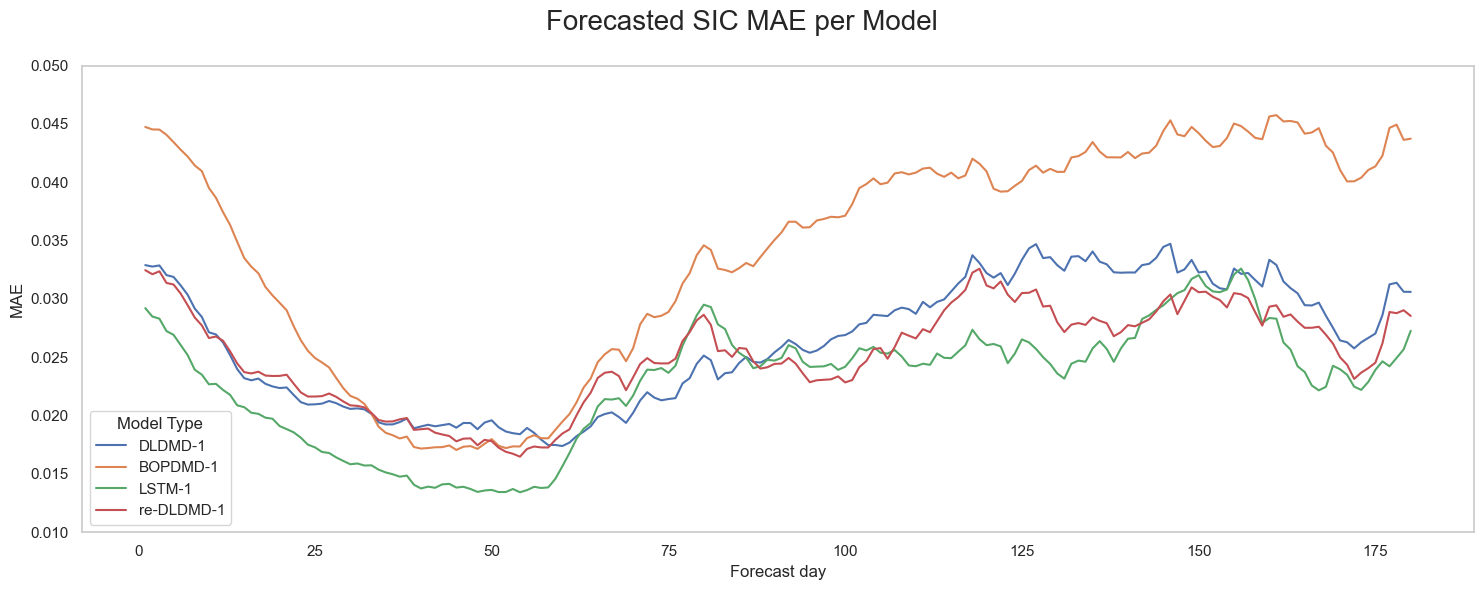

In [21]:
import seaborn as sns

sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 1, figsize=(15, 6))

ax1 = sns.lineplot(melt_mae, x='pred_day', y = 'MAE',  hue = 'Model Type', ax =axs )
ax1.grid(False)
ax1.set(xlabel='Forecast day')
ax1.set_ylim([0.01, 0.05])

fig.subplots_adjust(hspace=-1)
fig.suptitle("Forecasted SIC MAE per Model", size = 20)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)
plt.tight_layout(h_pad=3, w_pad = 3)




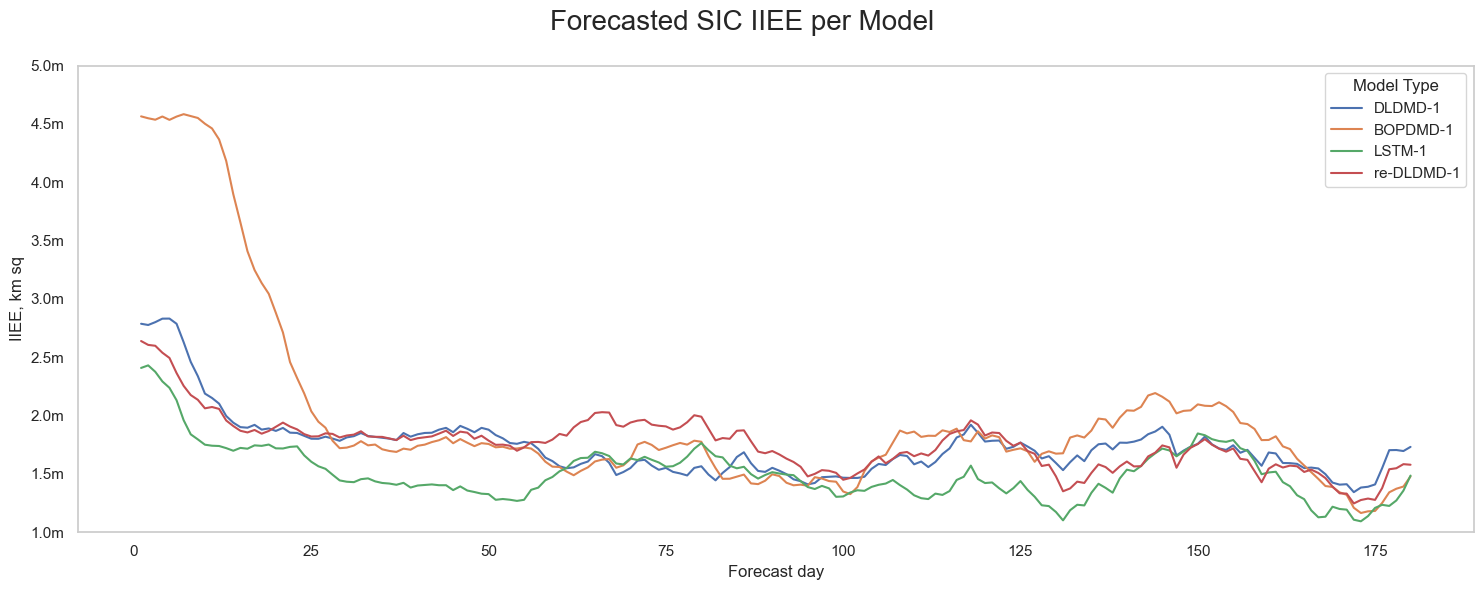

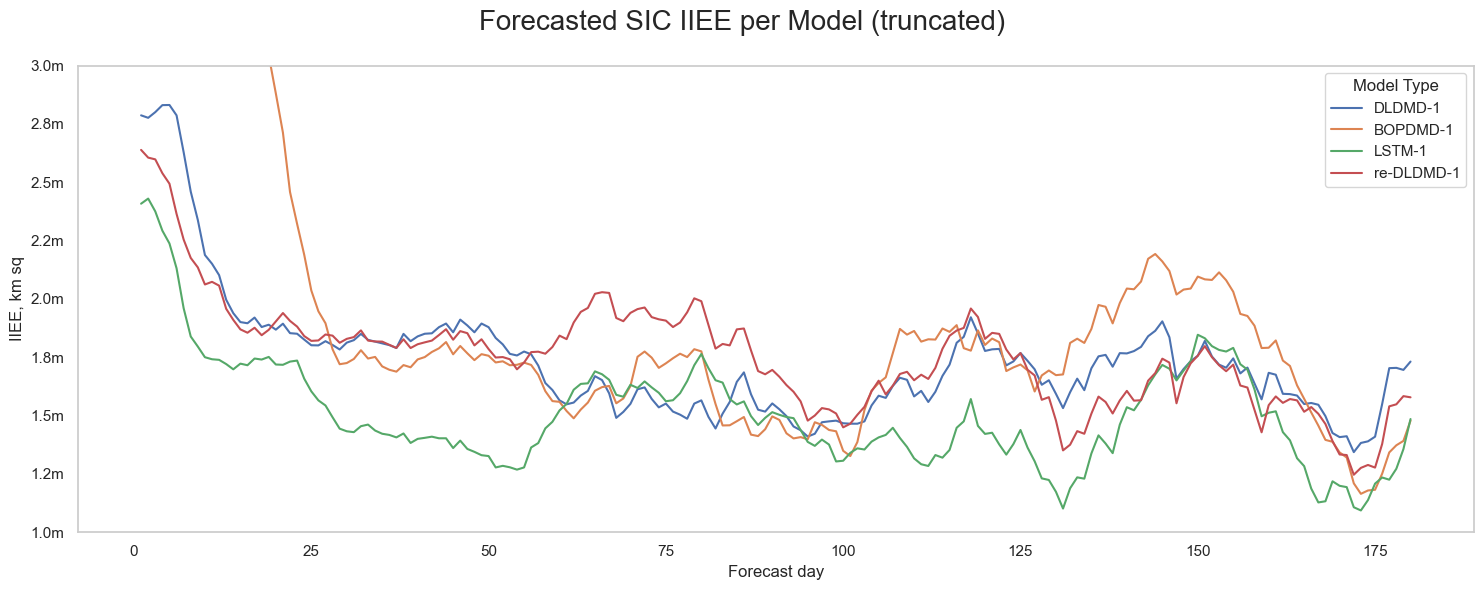

In [22]:
import seaborn as sns

sns.set(style="whitegrid")
fig1, axs2 = plt.subplots(1, 1, figsize=(15, 6))

ax2 = sns.lineplot(melt_iiee, x='pred_day', y = 'IIEE',  hue = 'Model Type', ax =axs2 )
ax2.grid(False)
ax2.set(xlabel='Forecast day',ylabel = 'IIEE, km sq')
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.set_ylim([1e6, 5e6])


#fig1.subplots_adjust(hspace=-1)
fig1.suptitle("Forecasted SIC IIEE per Model", size = 20)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)
plt.tight_layout(h_pad=3, w_pad = 3)


fig2, axs3 = plt.subplots(1, 1, figsize=(15, 6))
ax3 = sns.lineplot(melt_iiee, x='pred_day', y = 'IIEE',  hue = 'Model Type', ax =axs3 )
ax3.grid(False)
ax3.set(xlabel='Forecast day',ylabel = 'IIEE, km sq')
ax3.yaxis.set_major_formatter(formatter_mil)
ax3.set_ylim([1e6, 3e6])


#fig2.subplots_adjust(hspace=-1)
fig2.suptitle("Forecasted SIC IIEE per Model (truncated)", size = 20)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)
plt.tight_layout(h_pad=3, w_pad = 3)

In [23]:
melt_trueint_slim = melt_trueint.drop("Model Type", axis = 1)
melt_trueint_slim.drop_duplicates(inplace= True)
melt_trueint_slim.insert(0, "Model Type", 'True Ice')

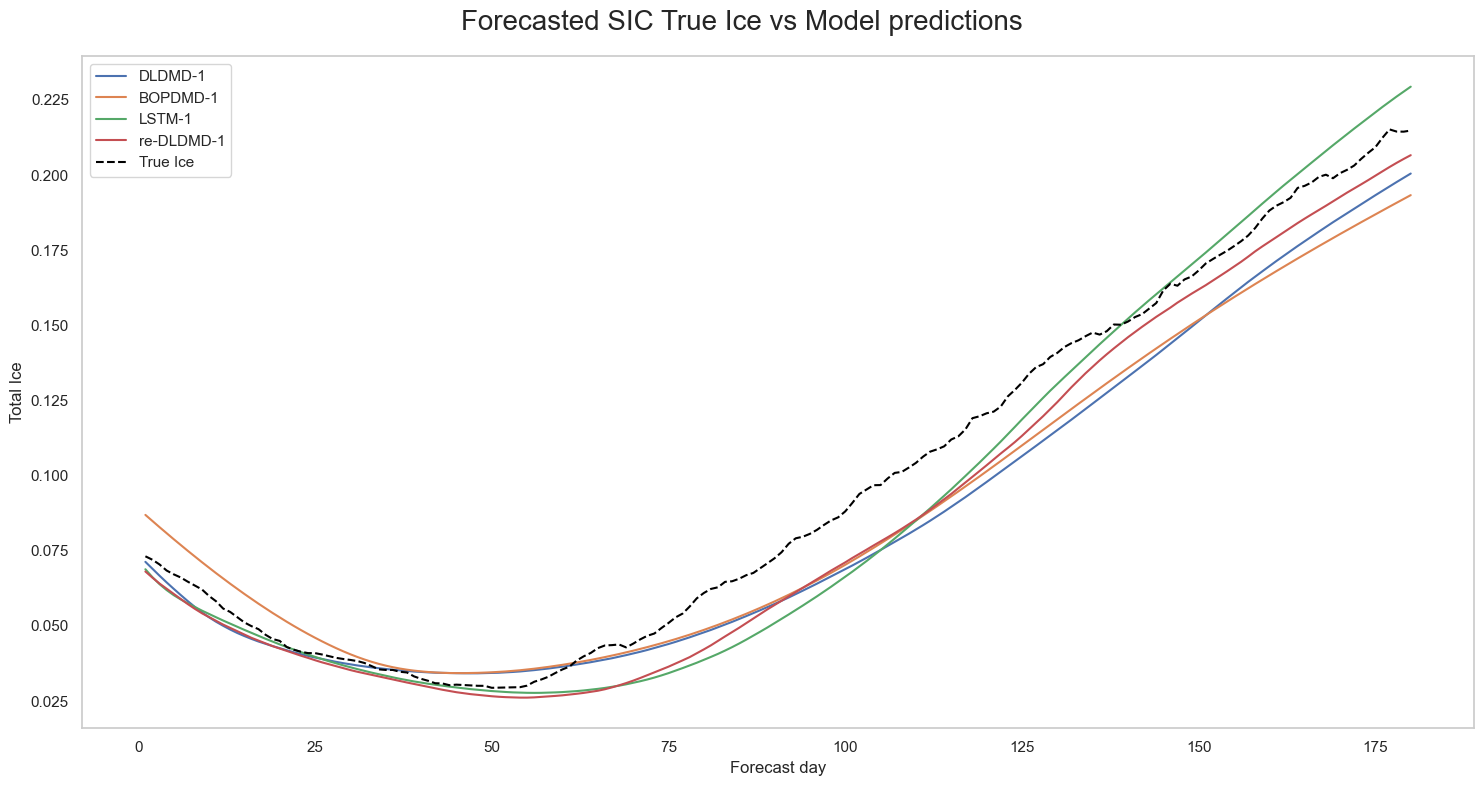

In [24]:
import seaborn as sns

sns.set(style="whitegrid")
fig3, axs3 = plt.subplots(1, 1, figsize=(15, 8))

ax4 = sns.lineplot(melt_predint, x='pred_day', y = 'Pred',  hue = 'Model Type', ax =axs3 )
sns.lineplot(melt_trueint_slim, x='pred_day', y = 'True',label = "True Ice",   ax =axs3 , linewidth = 1.5, color='black', linestyle='--')
ax4.grid(False)
ax4.set(xlabel='Forecast day')
ax4.set(ylabel='Total Ice')
#ax4.set_ylim([0.01, 0.05])

fig3.suptitle("Forecasted SIC True Ice vs Model predictions", size = 20)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)
plt.tight_layout(h_pad=3, w_pad = 3)

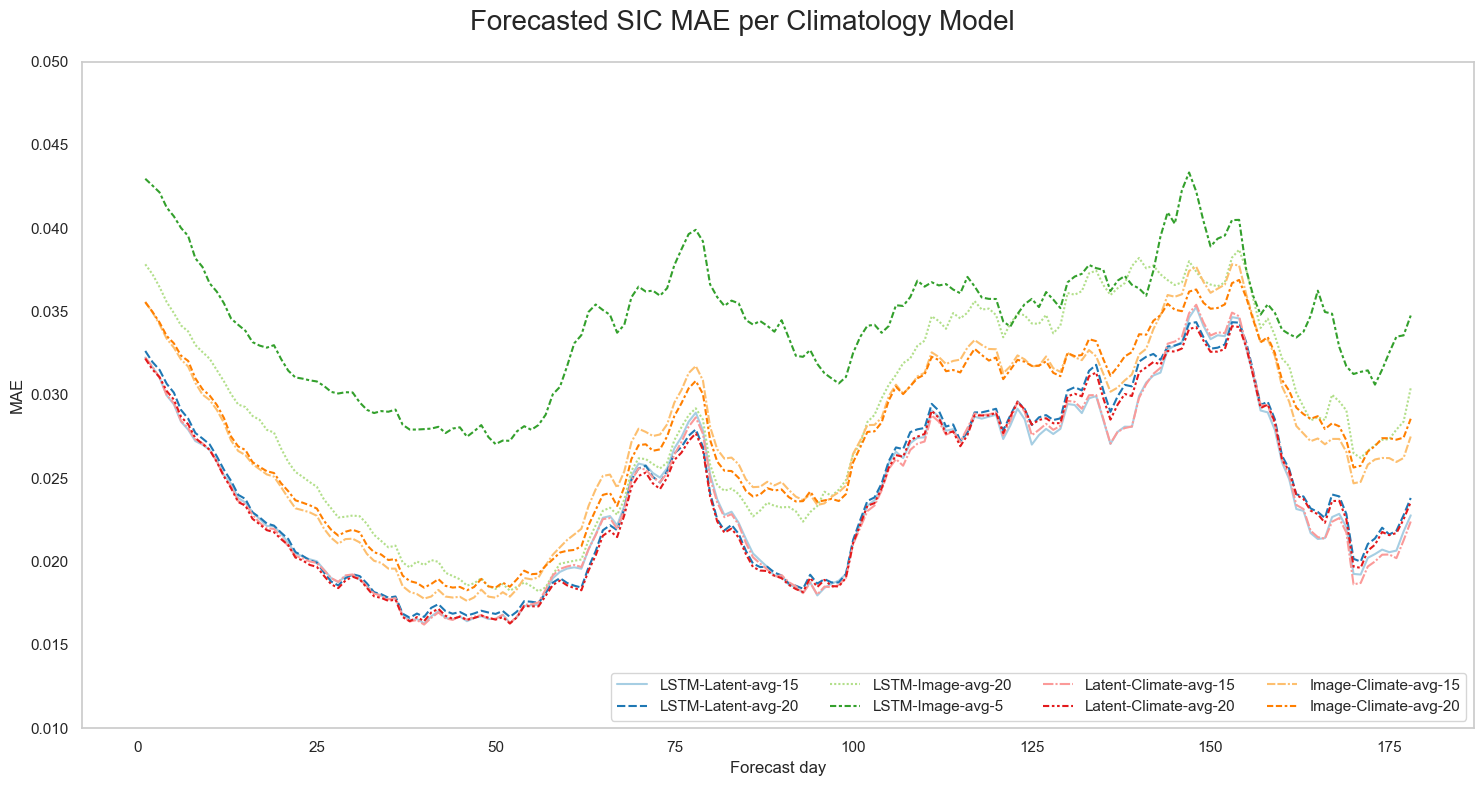

In [25]:
import seaborn as sns

sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 1, figsize=(15, 8))

#sns.color_palette("tab10")

ax1 = sns.lineplot(melt_mae_c, x='pred_day', y = 'MAE',  hue = 'Model Type', ax =axs, palette= 'Paired' , style = 'Model Type')
ax1.grid(False)
ax1.set(xlabel='Forecast day')
ax1.set_ylim([0.01, 0.05])

fig.subplots_adjust(hspace=-1)
fig.suptitle("Forecasted SIC MAE per Climatology Model", size = 20)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)

#ax1.get_legend().remove()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc="lower right", ncol=4)

plt.tight_layout(h_pad=4, w_pad = 4)

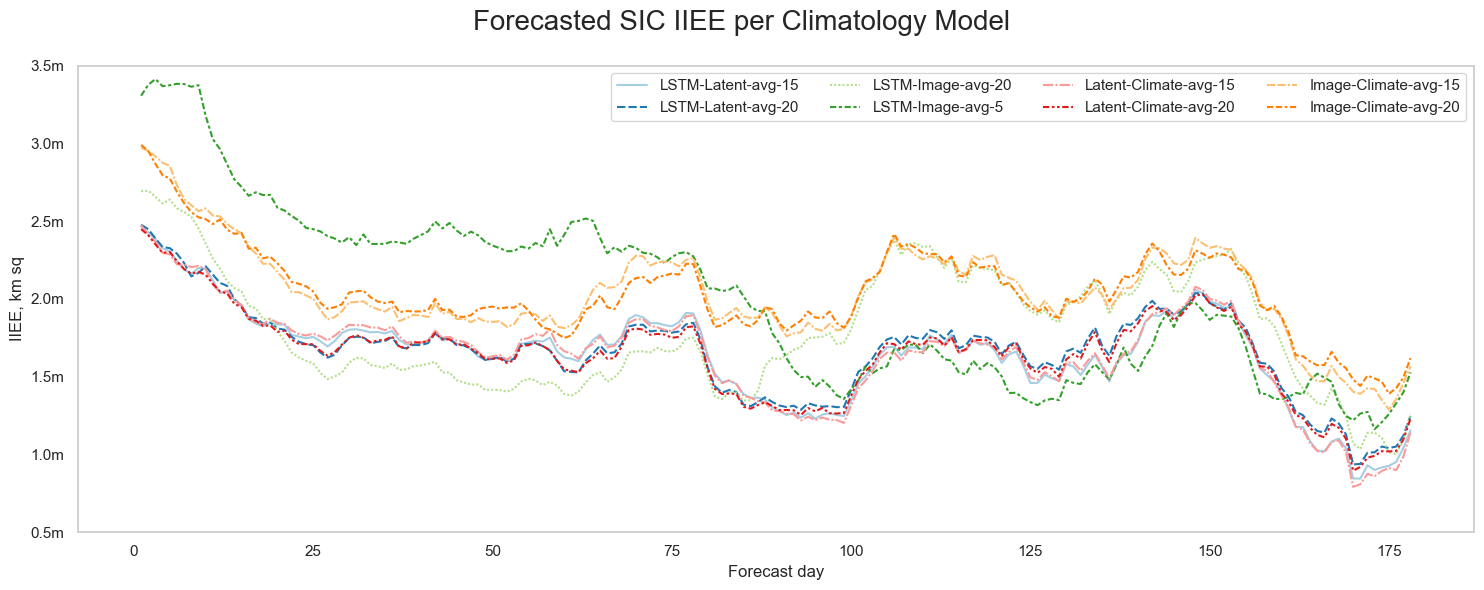

In [26]:
import seaborn as sns

sns.set(style="whitegrid")
fig1c, axs2 = plt.subplots(1, 1, figsize=(15, 6))

ax2 = sns.lineplot(melt_iiee_c, x='pred_day', y = 'IIEE',  hue = 'Model Type', ax =axs2 ,palette= 'Paired' , style = 'Model Type')
ax2.grid(False)
ax2.set(xlabel='Forecast day', ylabel = 'IIEE, km sq')
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.set_ylim([0.5e6, 3.5e6])


#fig1.subplots_adjust(hspace=-1)
fig1c.suptitle("Forecasted SIC IIEE per Climatology Model", size = 20)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)
lines_labels = [ax.get_legend_handles_labels() for ax in fig1c.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax2.legend(lines, labels, loc="upper right", ncol=4)

plt.tight_layout(h_pad=3, w_pad = 3)

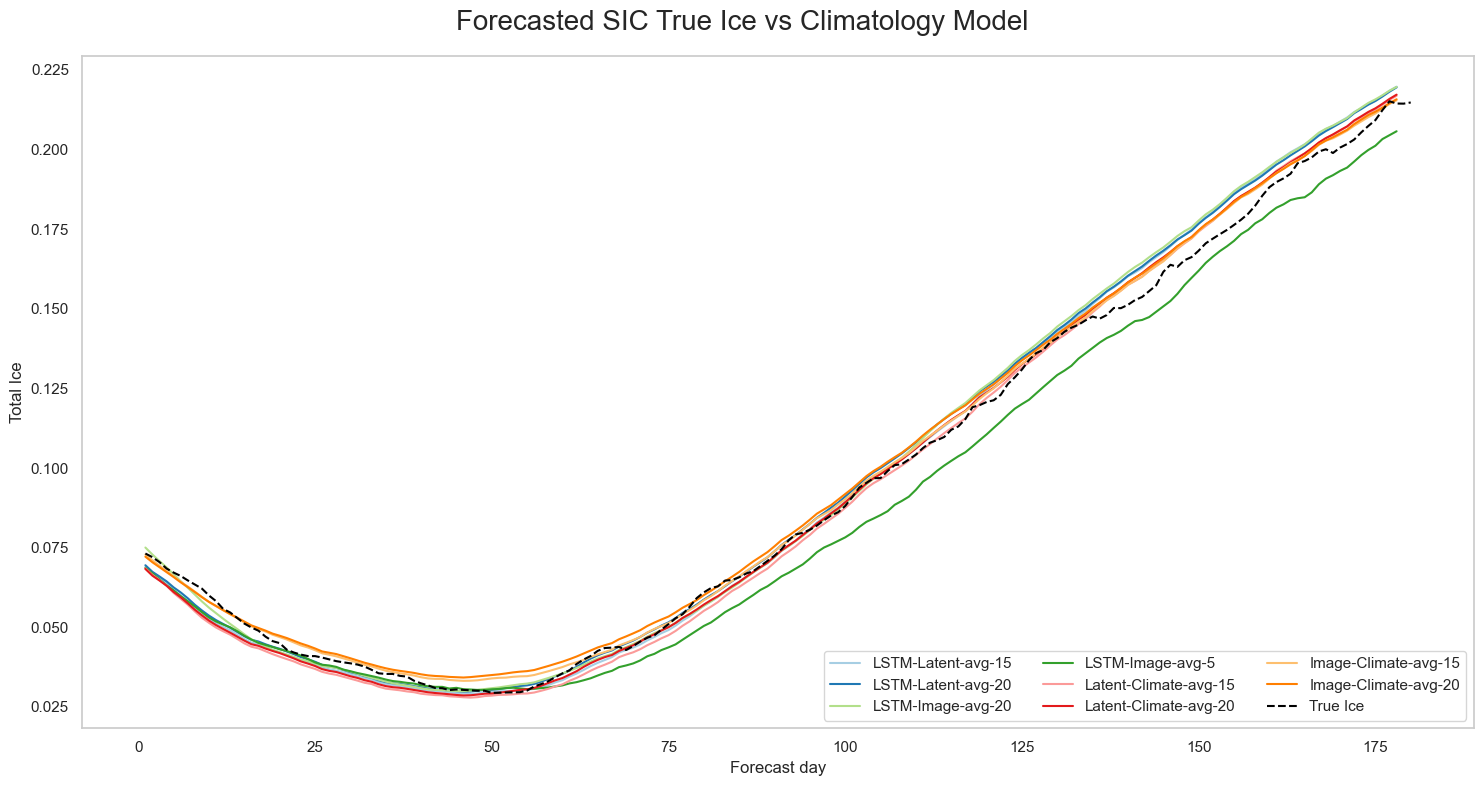

In [27]:
import seaborn as sns

sns.set(style="whitegrid")
fig3, axs3 = plt.subplots(1, 1, figsize=(15, 8))

ax4 = sns.lineplot(melt_predint_c, x='pred_day', y = 'Pred',  hue = 'Model Type', ax =axs3 ,palette= 'Paired')
sns.lineplot(melt_trueint_slim, x='pred_day', y = 'True',label = "True Ice",   ax =axs3 , linewidth = 1.5, color='black', linestyle='--')
ax4.grid(False)
ax4.set(xlabel='Forecast day')
ax4.set(ylabel='Total Ice')
#ax4.set_ylim([0.01, 0.05])

fig3.suptitle("Forecasted SIC True Ice vs Climatology Model", size = 20)
lines_labels = [ax.get_legend_handles_labels() for ax in fig3.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax4.legend(lines, labels, loc="lower right", ncol=3)
#ax1.title.set_text("Forecasted SIC MAE per Models",size = 20, y=1)
plt.tight_layout(h_pad=3, w_pad = 3)

In [28]:
"""Encoded Latent space examples across moving average windows"""

file_win1 = import_dir + 'encoded_images/latent_win_1_train'
file_win5 = import_dir + 'encoded_images/latent_win_5_train'
file_win10 = import_dir + 'encoded_images/latent_win_10_train'
file_win20 = import_dir + 'encoded_images/latent_win_20_train'

with open(file_win1, "rb") as in_data:
    win1 = pickle.load(in_data)

with open(file_win5, "rb") as in_data:
    win5 = pickle.load(in_data)

with open(file_win10, "rb") as in_data:
    win10 = pickle.load(in_data)

with open(file_win20, "rb") as in_data:
    win20 = pickle.load(in_data)


win1 = win1.detach().cpu().numpy()
win5 = win5.detach().cpu().numpy()
win10 = win10.detach().cpu().numpy()
win20 = win20.detach().cpu().numpy()

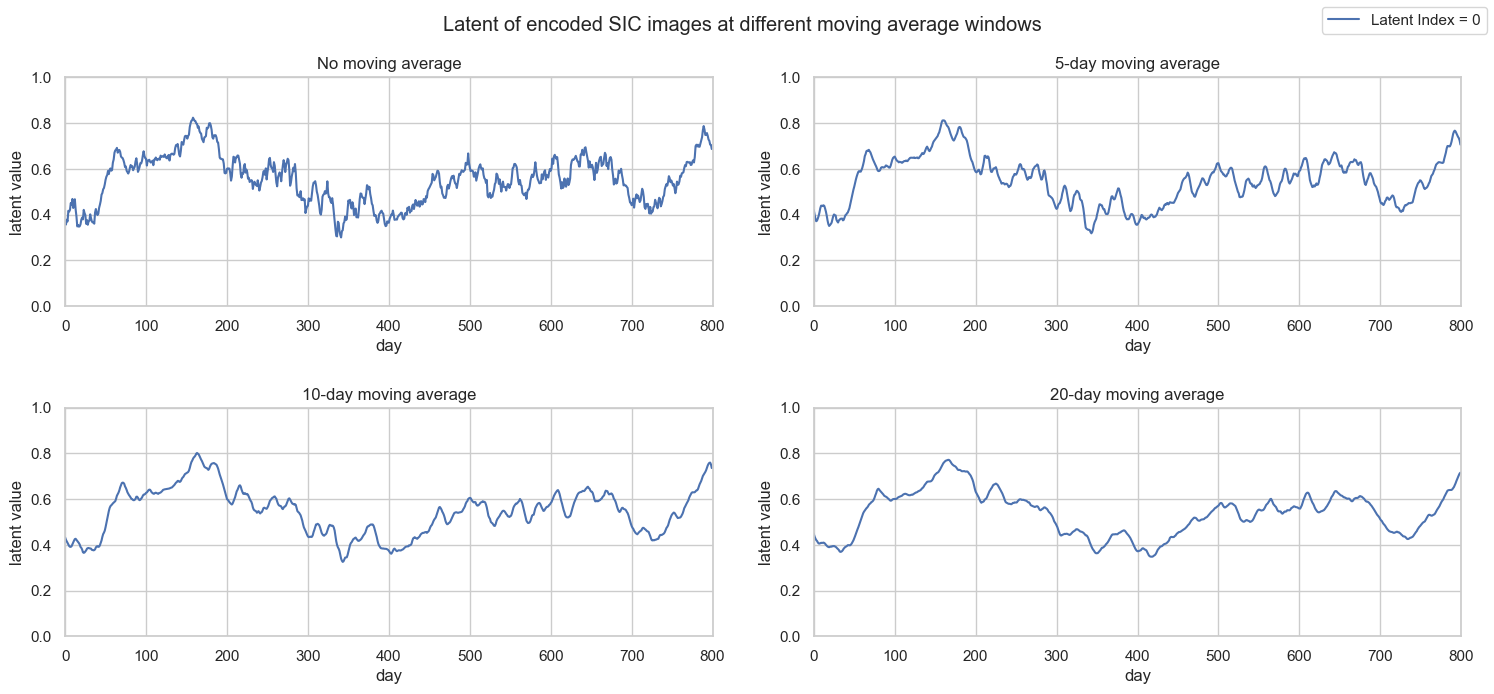

In [29]:
import seaborn as sns

fig_1, axs = plt.subplots(2,2, figsize=(15,7))
sns.set(style="whitegrid")
#sns.set(style="darkgrid")
sns.color_palette("crest", as_cmap=True)
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax1 = sns.lineplot(win1[-800:,0],  ax =axs[0][0], label = 'Latent Index = 0')
ax1.set_title("No moving average")
ax1.grid(True)
ax1.set_ylim([0 ,1.0])
ax1.set_xlim([0 ,800])
ax1.set(xlabel='day', ylabel="latent value")

ax2 = sns.lineplot(win5[-800:,0],  ax =axs[0][1])
ax2.set_title("5-day moving average")
ax2.grid(True)
ax2.set_ylim([0 ,1.0])
ax2.set_xlim([0 ,800])
ax2.set(xlabel='day', ylabel="latent value")

ax3 = sns.lineplot(win10[-800:,0],  ax =axs[1][0])
ax3.set_title("10-day moving average")
ax3.grid(True)
ax3.set_ylim([0 ,1.0])
ax3.set_xlim([0 ,800])
ax3.set(xlabel='day', ylabel="latent value")

ax4 = sns.lineplot(win20[-800:,0],  ax =axs[1][1])
ax4.set_title("20-day moving average")
ax4.grid(True)
ax4.set_ylim([0 ,1.0])
ax4.set_xlim([0 ,800])
ax4.set(xlabel='day', ylabel="latent value")

fig_1.suptitle("Latent of encoded SIC images at different moving average windows")




ax1.get_legend().remove()
lines_labels = [ax.get_legend_handles_labels() for ax in fig_1.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig_1.legend(lines, labels, loc="upper right", ncol=2)

plt.tight_layout(h_pad=2, w_pad = 2)

In [30]:

# ax2 = axs[0][0].twinx()
# sns.lineplot(data=melted_dfs[1], x='pred_day', y = 'IIEE',color="r", ax=ax2, label ='IIEE')
# ax2.yaxis.set_major_formatter(formatter_mil)
# ax2.grid(False)
# ax2.set(ylabel='IIEE, km sq')
# ax2.set_ylim([1e6, 3.0e6])

# ##################################

# ax3 = sns.lineplot(melted_dfs[2], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[0][1] )
# ax3.grid(False)
# ax3.set(xlabel='Forecast day')
# ax3.set_ylim([0.016, 0.042])
# ax3.title.set_text(title_list[1])

# ax4 = axs[0][1].twinx()
# sns.lineplot(data=melted_dfs[3], x='pred_day', y = 'IIEE',color="r", ax=ax4, label ='_IIEE')
# ax4.yaxis.set_major_formatter(formatter_mil)
# ax4.grid(False)
# ax4.set(ylabel='IIEE, km sq')
# ax4.set_ylim([1e6, 3.0e6])

# ################################################
# ax5 = sns.lineplot(melted_dfs[4], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][0] )
# ax5.grid(False)
# ax5.set(xlabel='Forecast day')
# ax5.set_ylim([0.016, 0.042])
# ax5.title.set_text(title_list[2])

# ax6 = axs[1][0].twinx()
# sns.lineplot(data=melted_dfs[5], x='pred_day', y = 'IIEE',color="r", ax=ax6, label ='_IIEE')
# ax6.yaxis.set_major_formatter(formatter_mil)
# ax6.grid(False)
# ax6.set(ylabel='IIEE, km sq')
# ax6.set_ylim([1e6, 3.0e6])

# ####################################################

# ax7 = sns.lineplot(melted_dfs[6], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][1] )
# ax7.grid(False)
# ax7.set(xlabel='Forecast day')
# ax7.set_ylim([0.016, 0.042])
# ax7.title.set_text(title_list[3])


# ax8 = axs[1][1].twinx()
# sns.lineplot(data=melted_dfs[7], x='pred_day', y = 'IIEE',color="r", ax=ax8, label ='_IIEE')
# ax8.yaxis.set_major_formatter(formatter_mil)
# ax8.grid(False)
# ax8.set(ylabel='IIEE, km sq')
# ax8.set_ylim([1e6, 3.0e6])

# #ax8.legend(loc = 'lower right')

# #handles, labels = plt.gca().get_legend_handles_labels()

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig.legend(lines, labels, loc="lower right", ncol=2)

# #fig.subplots_adjust(hspace=0.1)
# fig.suptitle("Sequential DLDMD - SIC forecast error per image", size = 20, y=1)

# axis_list = [ax1,ax2]

# for i in axis_list: i.get_legend().remove()

# #ax8.get_legend().remove()
# #plt.show()
# plt.tight_layout(h_pad=3, w_pad = 3)


In [31]:
# with open(pkl_dir + 'seq_dldmd_pred.pkl', 'wb') as output:
#     pickle.dump(pred_dec.numpy()[:180], output)
#     #del latent_train

In [32]:
#import seaborn as sns

In [33]:
# """plots using  window = 1, history = 2, svd = 5"""

# fig_1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

# sns.color_palette("crest", as_cmap=True)
# palette = get_hex("Aluterus_scriptus", keep_first_n=5)

# ax_1 = ax1.contourf(X1_[70], cmap=plt.get_cmap('Blues_r'))
# ax1.set_title("Truth")
# ax1.set_ylim(314, 0)
# cbar1 = fig_1.colorbar(ax_1)

# ax_2 = ax2.contourf(pred_dec.numpy()[70], cmap=plt.get_cmap('Blues_r'))
# ax2.set_title("Sequential DLDMD forecast")
# ax2.set_ylim(314, 0)
# cbar2 = fig_1.colorbar(ax_2)

# sns.set(style="darkgrid")

# fig_1.suptitle("Truth vs Sequential DLDMD forecast, 70 days forward")
# plt.show()

In [34]:
# fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(15,5))

# ax_3 = ax3.contourf(X1_[179], cmap=plt.get_cmap('Blues_r'))
# ax3.set_title("Truth")
# ax3.set_ylim(314, 0)
# cbar3 = fig_2.colorbar(ax_3)

# ax_4 = ax4.contourf(pred_dec.numpy()[179], cmap=plt.get_cmap('Blues_r'))
# ax4.set_title("Sequential DLDMD forecast")
# ax4.set_ylim(314, 0)
# cbar4 = fig_2.colorbar(ax_4)

# sns.set(style="darkgrid")

# fig_2.suptitle("Truth vs Sequential DLDMD forecast, 180 days forward")
# plt.show()

In [35]:
# def melt_frame_lineplot_any(input_mae,metric, qry):
#     temp_df = input_mae.query(qry)

#     temp_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )
#     temp_df['pred_day'] = temp_df['pred_day']-2

#     return temp_df

In [36]:
# melted_int_dfs = []
# title_int_list = []

# for i in best_win_his:
#     m,n,o = i
#     input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)

#     out_df1 = melt_frame_lineplot_any(dmd_true_integral_df,"True" , input_qry)
#     out_df2 = melt_frame_lineplot_any(dmd_pred_integral_df,"Pred" , input_qry)
#     melted_int_dfs.append(out_df1)
#     melted_int_dfs.append(out_df2)
    
#     if m == 1:
#         temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
#     else:
#         temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
#     title_int_list.append(temp_title)

In [37]:
# import seaborn as sns

# sns.set(style="whitegrid")
# fig_int, axs_int = plt.subplots(2, 2, figsize=(15, 8))

# ax1_int = sns.lineplot(melted_int_dfs[0], x='pred_day', y = 'True', label ='True', ax =axs_int[0][0], color="b" )
# sns.lineplot(data=melted_int_dfs[1], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][0], label ='Pred')
# ax1_int.grid(False)
# ax1_int.set(xlabel='Forecast day')
# ax1_int.title.set_text(title_int_list[0])
# ax1_int.set_ylim([0.0, 0.25])
# ax1_int.set(ylabel="Total Ice")

# ax2_int = sns.lineplot(melted_int_dfs[2], x='pred_day', y = 'True', label ='_True', ax =axs_int[0][1], color="b" )
# sns.lineplot(data=melted_int_dfs[3], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][1], label ='_Pred')
# ax2_int.grid(False)
# ax2_int.set(xlabel='Forecast day')
# ax2_int.title.set_text(title_int_list[1])
# ax2_int.set_ylim([0.0, 0.25])
# ax2_int.set(ylabel="Total Ice")

# ax3_int = sns.lineplot(melted_int_dfs[4], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][0], color="b" )
# sns.lineplot(data=melted_int_dfs[5], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][0], label ='_Pred')
# ax3_int.grid(False)
# ax3_int.set(xlabel='Forecast day')
# ax3_int.title.set_text(title_int_list[2])
# ax3_int.set_ylim([0.0, 0.25])
# ax3_int.set(ylabel="Total Ice")


# ax4_int = sns.lineplot(melted_int_dfs[6], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][1], color="b" )
# sns.lineplot(data=melted_int_dfs[7], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][1], label ='_Pred')
# ax4_int.grid(False)
# ax4_int.set(xlabel='Forecast day')
# ax4_int.title.set_text(title_int_list[3])
# ax4_int.set_ylim([0.0, 0.25])
# ax4_int.set(ylabel="Total Ice")


# lines_labels = [ax.get_legend_handles_labels() for ax in fig_int.axes]

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig_int.legend(lines, labels, loc="lower right", ncol=2)

# #fig.subplots_adjust(hspace=0.1)
# fig_int.suptitle("Sequential DLDMD - Total Ice per forecasted day", size = 20, y=1)

# axis_list = [ax1_int]

# for i in axis_list: i.get_legend().remove()

# #ax8.get_legend().remove()
# #plt.show()
# plt.tight_layout(h_pad=3, w_pad = 3)


In [38]:
# melted_latent_dfs = []
# title_latent_list = []

# for i in best_win_his:
#     m,n,o = i
#     #input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)
#     for idx, j in enumerate(latent_space_pred):
#         if j[0] == i:
#             melted_latent_dfs.append(j[1])
#             melted_latent_dfs.append(latent_space_true[idx][1])
        
#             if m == 1:
#                 temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
#             else:
#                 temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
#             title_latent_list.append(temp_title)



In [39]:
# import seaborn as sns


# latent_idx = 0
# sns.set(style="whitegrid")
# fig_lat, axs_lat = plt.subplots(2, 2, figsize=(15, 8), constrained_layout=False)

# axs_lat[0][0].plot(melted_latent_dfs[0][:,latent_idx], label="pred latent idx = 0", color='green')
# axs_lat[0][0].plot(melted_latent_dfs[1][:,latent_idx], label="true latent idx = 0", color='orange')

# # axs_lat[0][0].plot(melted_latent_dfs[0][:,2])
# # axs_lat[0][0].plot(melted_latent_dfs[1][:,2])
# axs_lat[0][0].set_xlim(0, 180)
# axs_lat[0][0].set_ylim(0.4, 0.8)
# axs_lat[0][0].set_xlabel('Forecast day')
# axs_lat[0][0].set_ylabel('Latent value')
# axs_lat[0][0].set_title(title_latent_list[0])

# axs_lat[0][1].plot(melted_latent_dfs[2][:,latent_idx], label="_pred latent idx = 0",color='green')
# axs_lat[0][1].plot(melted_latent_dfs[3][:,latent_idx], label="_true latent idx = 0",color='orange')
# axs_lat[0][1].set_xlim(0, 180)
# axs_lat[0][1].set_ylim(0.4, 0.8)
# axs_lat[0][1].set_xlabel('Forecast day')
# axs_lat[0][1].set_ylabel('Latent value')
# axs_lat[0][1].set_title(title_latent_list[1])

# axs_lat[1][0].plot(melted_latent_dfs[4][:,latent_idx], label="_pred latent idx = 0",color='green')
# axs_lat[1][0].plot(melted_latent_dfs[5][:,latent_idx], label="_true latent idx = 0",color='orange')
# axs_lat[1][0].set_xlim(0, 180)
# axs_lat[1][0].set_ylim(0.4, 0.8)
# axs_lat[1][0].set_xlabel('Forecast day')
# axs_lat[1][0].set_ylabel('Latent value')
# axs_lat[1][0].set_title(title_latent_list[2])

# axs_lat[1][1].plot(melted_latent_dfs[6][:,latent_idx], label="_pred latent idx = 0",color='green')
# axs_lat[1][1].plot(melted_latent_dfs[7][:,latent_idx], label="_true latent idx = 0",color='orange')
# axs_lat[1][1].set_xlim(0, 180)
# axs_lat[1][1].set_ylim(0.4, 0.8)
# axs_lat[1][1].set_xlabel('Forecast day')
# axs_lat[1][1].set_ylabel('Latent value')
# axs_lat[1][1].set_title(title_latent_list[3])

# fig_lat.suptitle("Sequential DLDMD - latent space", size = 20, y=1)

# lines_labels = [ax.get_legend_handles_labels() for ax in fig_lat.axes]

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig_lat.legend(lines, labels, loc="lower center", ncol=2)

# plt.tight_layout(h_pad=3, w_pad = 3)

In [40]:
# with open(r'../outputs/seq_dmd_stats/all_seqdmd_stats_' + time.strftime("%Y%m%d"), 'wb') as output:
#      pickle.dump([dmd_avg_stat_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df,dmd_latent_recon_df, dmd_latent_fwd_df], output)

In [41]:
# with open(r'../outputs/seq_dmd_stats/all_seqdmd_stats_20240815', 'rb') as f:
#     loaded_df = pickle.load(f)

# dmd_avg_stat_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df,dmd_latent_recon_df, dmd_latent_fwd_df = loaded_df

In [42]:
# dmd_avg_stat_df.to_csv(stats_dir + "Seq_DMD_avg_stat_df.csv")

# dmd_latent_recon_df.to_csv(stats_dir + "Seq_DMD_latentrecon_stat_df.csv")
# dmd_latent_fwd_df.to_csv(stats_dir + "Seq_DMD_avg_latentfwd_df.csv")

In [43]:
# import seaborn as sns

# def query_boxplot(qry, metric, input_df, plt_title,shade = "BluetoGray_8", yxformat = None):
    
#     temp_df = input_df.query(qry)
#     melt_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )

#     fig, axs = plt.subplots(1, 1, figsize=(16, 7))

#     #palette = get_hex("Bmlunge")
#     sns.set_theme()
#     palette = get_hex(shade, keep_first_n=8)
#     sns.set_style("darkgrid")
#     ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
#     #ax_sns.set_title("Distribution of IIEE  - Forecasted SIC images")
#     ax_sns.set_title(plt_title)

#     if yxformat is not None:
#         ax_sns.yaxis.set_major_formatter(yxformat)

#     l = ax_sns.legend(title= 'History:', bbox_to_anchor=(0.2, -0.07), ncol = 5, loc = 'center', frameon=False)
#     #sns.move_legend(ax_sns, "center", bbox_to_anchor=(0.5, -0.15), ncol = 5, frameon=False)
#     l.get_title().set_position((-190, -21))

#     #sns.set_style()
#     plt.plot()

In [44]:
# win = 1
# svd_u = 11
# svd_l = 2

# input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(win, svd_u, svd_l)

# query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images" )
# query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images", yxformat = formatter)

# for i in [5,10,20]:
#     input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(i, svd_u, svd_l)
#     query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images, {}-day Moving averge".format(i) )
#     query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images, {}-day Moving averge".format(i), yxformat = formatter)